In [4]:
# -*- coding=UTF-8 -*-
import os, os.path as osp
import sys
from functools import reduce
import itertools
import time
import seaborn as sns
import copy
from pathlib import Path
from collections import defaultdict
# from modules.utils import collect, open_file, short_entry
import numpy as np
import cv2
from functools import partial
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, cohen_kappa_score, confusion_matrix, precision_recall_fscore_support
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [5]:
def log(*args, **kwargs):
  print(f'{time.strftime("%Y-%m-%d %H:%M:%S")}] ', *args, **kwargs)

In [6]:
task_name = "早期肠癌ML"

# random seed

seed = 10482
batch_size = 8
test_size = 0.84
kfold = 5

max_epoch = 36

save_dir_name1 = "paper_produce_model"
save_dir_name = osp.join(save_dir_name1, task_name, "20230109")
save_dir_name = osp.abspath(save_dir_name)
os.makedirs(save_dir_name, exist_ok=True)
save_dir_name


'Y:\\病理中心-结直肠癌患者淋巴结转移预测\\project\\Lymph_node_metastasisV2\\code\\paper_produce_model\\早期肠癌ML\\20230109'


# 机器学习

In [7]:
ori_lymph_data_df = pd.read_excel(r"Y:\病理中心-结直肠癌患者淋巴结转移预测\project\Lymph_node_metastasisV2\analysis_V2\data\早期肠癌第二篇最终版（546+105）4月30日.xlsx", sheet_name="美国变量")
ori_lymph_data_df["文件名"] =  ori_lymph_data_df["病理号"].apply(lambda f: osp.basename(osp.dirname(f)))
ori_lymph_data_df.head(30)

,Unnamed: 0,病理号,分级(C),脉管(D),LNM,美国（整合）变量预测结果,用途,整合变量0是阴性；1是阳性,文件名
0,s3,GR2016-00165,0,1,1,1,test,C，D其中任意1个或以上阳性则判定为阳性,
1,s5,GR2016-01080,0,0,0,0,test,分级：H（0）为阳性；其余为阴性。,
2,s7,GR2016-03231,0,0,0,0,test,NaN,
3,s15,GR2016-09896,0,0,0,0,test,NaN,
4,s26,GR2016-15495,0,0,0,0,test,NaN,
5,s34,GR2017-02584,0,0,0,0,test,NaN,
6,s43,GR2017-05930,0,0,0,0,test,NaN,
7,s49,GR2017-06686,0,0,0,0,test,NaN,
8,s52,GR2017-07107,0,0,0,0,test,NaN,
9,s54,GR2017-07745,0,0,0,0,test,NaN,


In [8]:
lymph_data_df = ori_lymph_data_df.copy()
log(len(lymph_data_df))
lymph_data_df.head(1)

2023-05-23 19:49:43]  105


,Unnamed: 0,病理号,分级(C),脉管(D),LNM,美国（整合）变量预测结果,用途,整合变量0是阴性；1是阳性,文件名
0,s3,GR2016-00165,0,1,1,1,test,C，D其中任意1个或以上阳性则判定为阳性,


In [10]:
ori_lymph_data_df

,Unnamed: 0,病理号,分级(C),脉管(D),LNM,美国（整合）变量预测结果,用途,整合变量0是阴性；1是阳性,文件名
0,s3,GR2016-00165,0,1,1,1,test,C，D其中任意1个或以上阳性则判定为阳性,
1,s5,GR2016-01080,0,0,0,0,test,分级：H（0）为阳性；其余为阴性。,
2,s7,GR2016-03231,0,0,0,0,test,NaN,
3,s15,GR2016-09896,0,0,0,0,test,NaN,
4,s26,GR2016-15495,0,0,0,0,test,NaN,
...,...,...,...,...,...,...,...,...,...
100,EN62,GR20-7707,0,0,0,0,test,NaN,
101,EN73,GR20-18929,0,0,0,0,test,NaN,
102,EN83,GR19-190,0,0,0,0,test,NaN,
103,EN94,GR19-5852,0,0,0,0,test,NaN,


In [8]:
lymph_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     105 non-null    object
 1   病理号            105 non-null    object
 2   分级(C)          105 non-null    int64 
 3   脉管(D)          105 non-null    int64 
 4   LNM            105 non-null    int64 
 5   美国（整合）变量预测结果   105 non-null    int64 
 6   用途             105 non-null    object
 7   整合变量0是阴性；1是阳性  2 non-null      object
 8   文件名            105 non-null    object
dtypes: int64(4), object(5)
memory usage: 7.5+ KB


In [11]:
lymph_data_df[~lymph_data_df.isna()]

,Unnamed: 0,病理号,分级(C),脉管(D),LNM,美国（整合）变量预测结果,用途,整合变量0是阴性；1是阳性,文件名
0,s3,GR2016-00165,0,1,1,1,test,C，D其中任意1个或以上阳性则判定为阳性,
1,s5,GR2016-01080,0,0,0,0,test,分级：H（0）为阳性；其余为阴性。,
2,s7,GR2016-03231,0,0,0,0,test,NaN,
3,s15,GR2016-09896,0,0,0,0,test,NaN,
4,s26,GR2016-15495,0,0,0,0,test,NaN,
...,...,...,...,...,...,...,...,...,...
100,EN62,GR20-7707,0,0,0,0,test,NaN,
101,EN73,GR20-18929,0,0,0,0,test,NaN,
102,EN83,GR19-190,0,0,0,0,test,NaN,
103,EN94,GR19-5852,0,0,0,0,test,NaN,


In [12]:
lymph_data_df = lymph_data_df.applymap(lambda v: v if isinstance(v, str) else (-1 if np.isnan(v) else v))

In [13]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [14]:
Y_GT_neg_num = np.sum(lymph_data_df["LNM"] == 1)
sorted_lymph_data_df = lymph_data_df.sort_values("LNM")
Y_GT_neg = sorted_lymph_data_df[:Y_GT_neg_num]
Y_GT_pos = sorted_lymph_data_df.iloc[Y_GT_neg_num:].sample(n=Y_GT_neg_num, random_state=seed)
balance_lymph_data_df = pd.concat([Y_GT_neg, Y_GT_pos])
balance_lymph_data_df.reset_index(drop=True, inplace=True)
balance_lymph_data_df.sample(frac=1, random_state=seed).reset_index(drop=True)
balance_lymph_data_df.head()
balance_lymph_data_df = lymph_data_df.copy()

In [15]:
lymph_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     105 non-null    object
 1   病理号            105 non-null    object
 2   分级(C)          105 non-null    int64 
 3   脉管(D)          105 non-null    int64 
 4   LNM            105 non-null    int64 
 5   美国（整合）变量预测结果   105 non-null    int64 
 6   用途             105 non-null    object
 7   整合变量0是阴性；1是阳性  105 non-null    object
 8   文件名            105 non-null    object
dtypes: int64(4), object(5)
memory usage: 7.5+ KB


In [16]:
X_INP = balance_lymph_data_df.copy()
X_INP = X_INP.replace(np.inf, -1)

hm_feat_list = [
  "美国（整合）变量预测结果","LNM"
  ]
X_INP = X_INP[hm_feat_list]

In [17]:
est_scores=X_INP['美国（整合）变量预测结果']

In [18]:
est_val_Y=X_INP['LNM']

In [19]:
threshold_confusion = 0.25
print( "\nConfusion matrix:  Costum threshold (for positive) of " + str(threshold_confusion))
y_pred = np.empty((est_scores.shape[0]))
for i in range(est_scores.shape[0]):
    if est_scores[i] >= threshold_confusion:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
confusion = confusion_matrix(est_val_Y, y_pred)
print(confusion)
accuracy = 0
if float(np.sum(confusion)) != 0:
    accuracy = float(confusion[0, 0]+confusion[1, 1])/float(np.sum(confusion))
    s = float(confusion[1, 1]+confusion[1, 0])/float(np.sum(confusion))
    p = float(confusion[1, 1]+confusion[0, 1])/float(np.sum(confusion))
    inter = float(confusion[1, 1])/float(np.sum(confusion))
print("Global Accuracy: " + str(accuracy))
specificity = 0
if float(confusion[0, 0]+confusion[0, 1]) != 0:
    specificity = float(confusion[0, 0])/float(confusion[0, 0]+confusion[0, 1])
print("Specificity: " + str(specificity))
sensitivity = 0
if float(confusion[1, 1]+confusion[1, 0]) != 0:
    sensitivity = float(confusion[1, 1])/float(confusion[1, 1]+confusion[1, 0])
print("Sensitivity: " + str(sensitivity))
precision = 0
if float(confusion[1, 1]+confusion[0, 1]) != 0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
print("Precision: " + str(precision))

recall = 0
if float(confusion[1, 1]+confusion[1, 0]) != 0:
    recall = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print("recall: " + str(recall))
G = 0
G = float(np.sqrt(sensitivity * specificity))
print ("G score: " + str(G))

MCC = 0
MCC = float(inter-s*p)/float(np.sqrt(p*s*(1-s)*(1-p)))
print("MCC: " + str(MCC))

# Jaccard similarity index
jaccard_index = jaccard_score(est_val_Y, y_pred)
print("\nJaccard similarity score: " + str(jaccard_index))

# F1 score
F1_score = f1_score(est_val_Y, y_pred, labels=None, average='binary', sample_weight=None)
print("\nF1 score (F-measure): " + str(F1_score))


Confusion matrix:  Costum threshold (for positive) of 0.25
[[80 17]
 [ 1  7]]
Global Accuracy: 0.8285714285714286
Specificity: 0.8247422680412371
Sensitivity: 0.875
Precision: 0.2916666666666667
recall: 0.875
G score: 0.8494995494619656
MCC: 0.44210032957774753


NameError: name 'jaccard_score' is not defined


Area under the ROC curve: 0.8498711340206184

Area under Precision-Recall curve: 0.5880952380952382


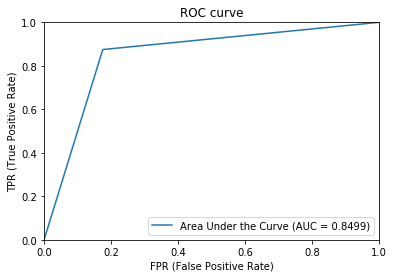

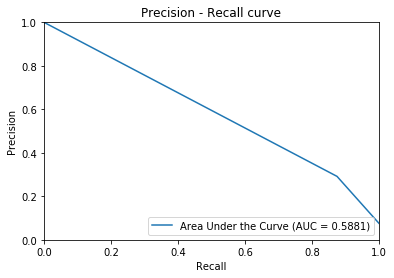

In [20]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
import scipy.io
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(est_val_Y, est_scores)
AUC_ROC = roc_auc_score(est_val_Y, est_scores)
scipy.io.savemat(f"{save_dir_name}/美国.mat", {'fpr':fpr, 'tpr':tpr, 'th':thresholds, 'auc':AUC_ROC})
np.save(f"{save_dir_name}/美国.npy", np.asarray([est_val_Y, y_pred]))
data_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'th':thresholds})
data_roc.to_excel(r"Y:/病理中心-结直肠癌患者淋巴结转移预测/project/Lymph_node_metastasisV2/analysis_V2/\roc_USA.xlsx", index=False)

# test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
print("\nArea under the ROC curve: " + str(AUC_ROC))
roc_curve = plt.figure()
plt.plot(fpr, tpr, '-', label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.legend(loc="lower right")
plt.savefig(f"{save_dir_name}/AUC.png")

#pr
precision, recall, thresholds = precision_recall_curve(est_val_Y, est_scores>=threshold_confusion)
precision = np.fliplr([precision])[0]  # so the array is increasing (you won't get negative AUC) 作用是将数组在左右方向上翻转。
recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
AUC_prec_rec = np.trapz(precision, recall)  # 梯形数值积分
print("\nArea under Precision-Recall curve: " + str(AUC_prec_rec))
prec_rec_curve = plt.figure()
plt.plot(recall, precision, '-', label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.legend(loc="lower right")
plt.savefig(f"{save_dir_name}/Pr.png")

D:\software\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


ValueError: String "major" must be one of: "on", "off", "true", or "false"

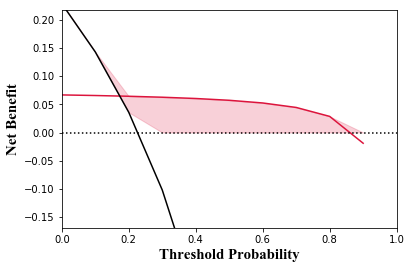

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
    net_benefit_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        n = len(y_label)
        net_benefit = (tp / n) - (fp / n) * (thresh / (1 - thresh))
        net_benefit_model = np.append(net_benefit_model, net_benefit)
    return net_benefit_model


def calculate_net_benefit_all(thresh_group, y_label):
    net_benefit_all = np.array([])
    tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel()
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp / total) - (tn / total) * (thresh / (1 - thresh))
        net_benefit_all = np.append(net_benefit_all, net_benefit)
    return net_benefit_all


def plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all):
    #Plot
    ax.plot(thresh_group, net_benefit_model, color = 'crimson', label = 'Model')
    ax.plot(thresh_group, net_benefit_all, color = 'black',label = 'Treat all')
    ax.plot((0, 1), (0, 0), color = 'black', linestyle = ':', label = 'Treat none')

    #Fill，显示出模型较于treat all和treat none好的部分
    y2 = np.maximum(net_benefit_all, 0)
    y1 = np.maximum(net_benefit_model, y2)
    ax.fill_between(thresh_group, y1, y2, color = 'crimson', alpha = 0.2)

    #Figure Configuration， 美化一下细节
    ax.set_xlim(0,1)
    ax.set_ylim(net_benefit_model.min() - 0.15, net_benefit_model.max() + 0.15)#adjustify the y axis limitation
    ax.set_xlabel(
        xlabel = 'Threshold Probability', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax.set_ylabel(
        ylabel = 'Net Benefit', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax.grid('major')
    ax.spines['right'].set_color((0.8, 0.8, 0.8))
    ax.spines['top'].set_color((0.8, 0.8, 0.8))
    ax.legend(loc = 'upper right')

    return ax


if __name__ == '__main__':
    #构造一个分类效果不是很好的模型
    y_pred_score = est_val_Y
    y_label = est_scores

    thresh_group = np.arange(0,1,0.1)
    net_benefit_model = calculate_net_benefit_model(thresh_group, y_pred_score, y_label)
    net_benefit_all = calculate_net_benefit_all(thresh_group, y_label)
    fig, ax = plt.subplots()
    ax = plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all)
    # fig.savefig('fig1.png', dpi = 300)
    plt.show()


In [22]:
## 绘制决策边界
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
    net_benefit_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        n = len(y_label)
        net_benefit = (tp / n) - (fp / n) * (thresh / (1 - thresh))
        net_benefit_model = np.append(net_benefit_model, net_benefit)
    return net_benefit_model


def calculate_net_benefit_all(thresh_group, y_label):
    net_benefit_all = np.array([])
    tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel()
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp / total) - (tn / total) * (thresh / (1 - thresh))
        net_benefit_all = np.append(net_benefit_all, net_benefit)
    return net_benefit_all


def plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all):
    #Plot
    ax.plot(thresh_group, net_benefit_model, color = 'crimson', label = 'Model')
    ax.plot(thresh_group, net_benefit_all, color = 'black',label = 'Treat all')
    ax.plot((0, 1), (0, 0), color = 'black', linestyle = ':', label = 'Treat none')

    #Fill，显示出模型较于treat all和treat none好的部分
    y2 = np.maximum(net_benefit_all, 0)
    y1 = np.maximum(net_benefit_model, y2)
    ax.fill_between(thresh_group, y1, y2, color = 'crimson', alpha = 0.2)

    #Figure Configuration， 美化一下细节
    ax.set_xlim(0,1)
    ax.set_ylim(net_benefit_model.min() - 0.15, net_benefit_model.max() + 0.15)#adjustify the y axis limitation
    ax.set_xlabel(
        xlabel = 'Threshold Probability', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax.set_ylabel(
        ylabel = 'Net Benefit', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
#     ax.grid('major')
    ax.spines['right'].set_color((0.8, 0.8, 0.8))
    ax.spines['top'].set_color((0.8, 0.8, 0.8))
    ax.legend(loc = 'upper right')

    return ax

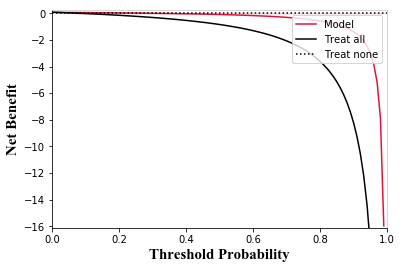

In [23]:
thresh_group = np.arange(0,1,0.01)
net_benefit_model = calculate_net_benefit_model(thresh_group, est_scores, est_val_Y)
net_benefit_all = calculate_net_benefit_all(thresh_group, est_val_Y)
fig, ax = plt.subplots()
ax = plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all)
# fig.savefig('fig1.png', dpi = 300)
plt.show()

In [23]:
data_Decision_curve = pd.DataFrame({"thresh_group": thresh_group,"net_benefit_model":net_benefit_model,
                                   "net_benefit_all": net_benefit_all})

data_Decision_curve.to_excel(r"Y:/病理中心-结直肠癌患者淋巴结转移预测/project/Lymph_node_metastasisV2/analysis_V2/DC_USA.xlsx",
                            index=False)

In [24]:
# 计算 AUC的95CI
def bootstrap_auc(y, pred, classes, bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))

    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        # df.
        df.loc[:, 'y'] = y
        df.loc[:, 'pred'] = pred
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = roc_auc_score(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics
statistics = bootstrap_auc(est_val_Y, est_scores, [0,1])
print("均值:",np.mean(statistics,axis=1))
print("最大值:",np.max(statistics,axis=1))
print("最小值:",np.min(statistics,axis=1))

均值: [0.84821021 0.84903682]
最大值: [0.89738125 0.9043451 ]
最小值: [0.79947397 0.79444175]


In [27]:
data_95ci_df = pd.DataFrame({"predict":est_scores,"label":est_val_Y})
data_95ci_df.to_excel(r"Y:\病理中心-结直肠癌患者淋巴结转移预测\project\Lymph_node_metastasisV2\analysis_V2\Delong_test\USA.xlsx", index=False)